**Датасет:**https://www.kaggle.com/datasets/dylanjcastillo/7k-books-with-metadata

Содержит в себе описание около 7 тысяч книг, обладает следующими признаками: уникальные номера isbn10 и isbn13, название, подзаголовок, авторы, жанр, описание, год публикации, средний рейтинг, количество страниц и отзывов.

**Описание задачи:** Я буду решать задачу регрессии, чтобы предсказывать рейтинг книги.

**Примечание:**  Есть признак "thumbnail", который представляет из себя изображение, участвовать в решении задачи он не будет, поэтому его можно сразу "дропнуть".

In [64]:
from google.colab import drive
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

drive.mount('/content/gdrive')
dataset = pd.read_csv('/content/gdrive/MyDrive/Dataset/books.csv')
dataset = dataset.drop(columns=['thumbnail'])

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Наглядно представим пропущенные значения:

<Axes: >

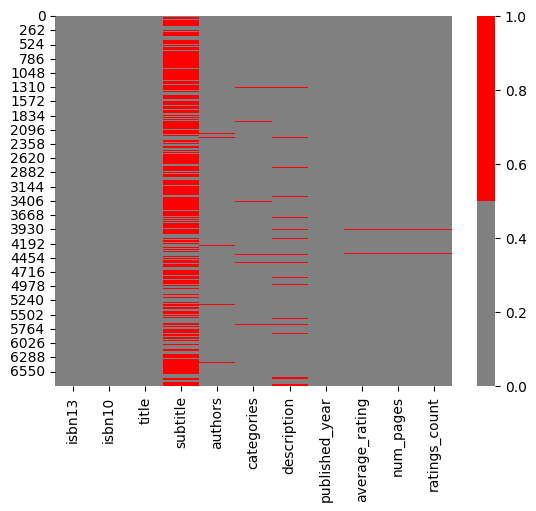

In [65]:
cols = dataset.columns
#gray - not missed, red - missed
colours = ['#808080', '#FF0000']
sns.heatmap(dataset[cols].isnull(), cmap=sns.color_palette(colours))

In [66]:
for col in dataset.columns:
    pct_missing = np.mean(dataset[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

isbn13 - 0%
isbn10 - 0%
title - 0%
subtitle - 65%
authors - 1%
categories - 1%
description - 4%
published_year - 0%
average_rating - 1%
num_pages - 1%
ratings_count - 1%


Рассмотрим типы признаков:

In [67]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810 entries, 0 to 6809
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   isbn13          6810 non-null   int64  
 1   isbn10          6810 non-null   object 
 2   title           6810 non-null   object 
 3   subtitle        2381 non-null   object 
 4   authors         6738 non-null   object 
 5   categories      6711 non-null   object 
 6   description     6548 non-null   object 
 7   published_year  6804 non-null   float64
 8   average_rating  6767 non-null   float64
 9   num_pages       6767 non-null   float64
 10  ratings_count   6767 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 585.4+ KB


Работать будем с признаками: 'published_year', 'num_pages', 'average_rating', 'ratings_count'. Я предположку, что не следует искать связь между isbn10(13) и средней оценкой книги, т.к. isbn - лишь уникальный номер. С текстовыми признаками пока что тоже не будем работать, ограничимся численными признаками и теми категориальными, которые можно обработать и привести к численным ('categories' - хороший кандидат).

Теперь посмотрим на выбросы:

In [68]:
columns_to_check = dataset[['published_year', 'num_pages', 'average_rating', 'ratings_count']]

columns_to_check

for feature in columns_to_check.columns:
    Q1 = dataset[feature].quantile(0.25)
    Q3 = dataset[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1 * IQR
    upper_bound = Q3 + 1 * IQR
    outliers = (dataset[feature] < lower_bound) | (dataset[feature] > upper_bound)
    print(feature + ': ' + str(outliers.sum()))

published_year: 616
num_pages: 606
average_rating: 423
ratings_count: 1165


Выбросы есть, и это вполне ожидаемо. Их не критически много, задача все еще очень даже выполнима. Взглянем на еще несколько характеристик:

In [69]:
min = columns_to_check.apply(lambda x: x.min())
max = columns_to_check.apply(lambda x: x.max())
delta = max - min

print(delta)

published_year        166.0
num_pages            3342.0
average_rating          5.0
ratings_count     5629932.0
dtype: float64


Теперь заполним пропущенные значения:

In [70]:
dataset['categories'].fillna('',inplace=True)
dataset['description'].fillna('',inplace=True)
dataset['authors'].fillna('',inplace=True)
dataset['subtitle'].fillna('',inplace=True)

for column in columns_to_check:
    median_value = dataset[column].median()
    dataset[column].fillna(int(median_value), inplace=True)

for col in dataset.columns:
    pct_missing = np.mean(dataset[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

isbn13 - 0%
isbn10 - 0%
title - 0%
subtitle - 0%
authors - 0%
categories - 0%
description - 0%
published_year - 0%
average_rating - 0%
num_pages - 0%
ratings_count - 0%


И обработаем признак 'categories'.  Для этого используем LabelEncoder из библиотеки scikit-learn. Параллельно с этим нормализуем и другие признаки.

In [71]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

dataset['categories'] = label_encoder.fit_transform(dataset['categories'])

columns_to_normalize = ['categories','published_year', 'average_rating', 'num_pages', 'ratings_count']

scaler = MinMaxScaler()

dataset[columns_to_normalize] = scaler.fit_transform(dataset[columns_to_normalize])

dataset

,isbn13,isbn10,title,subtitle,authors,categories,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,,Marilynne Robinson,0.601411,A NOVEL THAT READERS and critics have been eag...,0.909639,0.770,0.073908,0.000064
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,0.474427,A new 'Christie for Christmas' -- a full-lengt...,0.885542,0.766,0.072113,0.000917
2,9780006163831,0006163831,The One Tree,,Stephen R. Donaldson,0.082892,Volume Two of Stephen Donaldson's acclaimed se...,0.777108,0.794,0.143327,0.000031
3,9780006178736,0006178731,Rage of angels,,Sidney Sheldon,0.601411,"A memorable, mesmerizing heroine Jennifer -- b...",0.843373,0.786,0.153202,0.005246
4,9780006280897,0006280897,The Four Loves,,Clive Staples Lewis,0.349206,Lewis' work on the nature of love divides love...,0.897590,0.830,0.050868,0.005983
...,...,...,...,...,...,...,...,...,...,...,...
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,0.858907,This collection of the timeless teachings of o...,0.879518,0.902,0.158887,0.000018
6806,9788185944609,8185944601,Secrets Of The Heart,,Khalil Gibran,0.820106,,0.843373,0.816,0.022142,0.000058
6807,9788445074879,8445074873,Fahrenheit 451,,Ray Bradbury,0.250441,,0.909639,0.796,0.055655,0.001018
6808,9789027712059,9027712050,The Berlin Phenomenology,,Georg Wilhelm Friedrich Hegel,0.666667,Since the three volume edition ofHegel's Philo...,0.771084,0.000,0.062837,0.000000


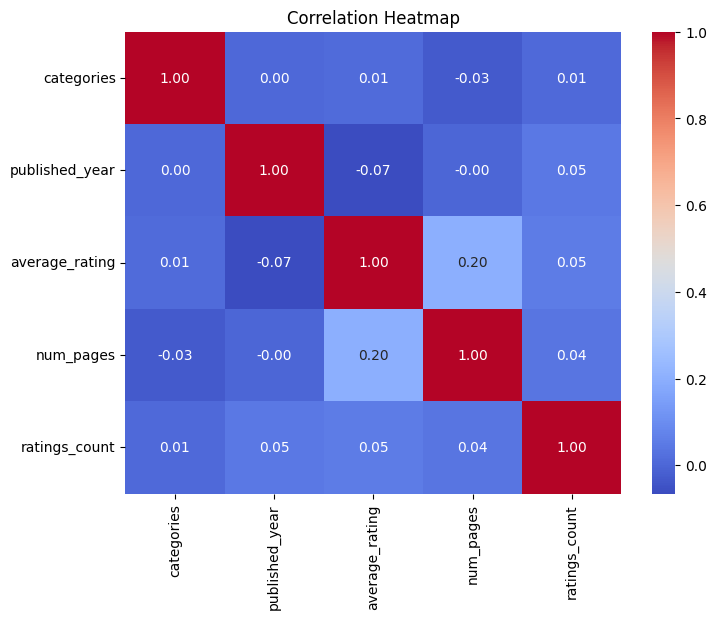

In [72]:
features = dataset[['categories', 'published_year', 'average_rating', 'num_pages', 'ratings_count']]

correlation_matrix = features.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Есть небольшая положительная корреляция между средней оценкой и количеством страниц, между остальными признаками корелляции практически нет.

Теперь определимся с методом решения задачи.

**Метод k ближаших соседий** нам **не подходит**, так как он чувствителен к выбросам. Также он медленный.

**Линейная регрессия** нам **не подходит**, так как предполагает простую зависимость данных.

Я предлагаю использовать методы **случайного леса**(без гиперпараметров) и **нейронных сетей**.

Начнем со случайного леса, для этого разобьем датасет на тестовую и обучающую выборку и запустим на них RandomForestRegressor из scikit-klearn.

In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

X = dataset.drop(['isbn13','isbn10', 'title', 'subtitle', 'authors', 'description', 'average_rating'], axis=1)
y = dataset['average_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35)

random_forest = RandomForestRegressor(n_estimators=100, random_state=54)

random_forest.fit(X_train, y_train)

predictions_test = random_forest.predict(X_test)
predictions_train = random_forest.predict(X_train)

r2_test = r2_score(y_test, predictions_test)
r2_train = r2_score(y_train, predictions_train)

mse_test = mean_squared_error(y_test, predictions_test)
mse_train = mean_squared_error(y_train, predictions_train)

print("r2_test =" + str(r2_test) + "MSE ="  + str(mse_test))
print("r2_train =" + str(r2_train) + "MSE =" + str(mse_train))

r2_test =0.07576531536596531MSE =0.004081026340939597
r2_train =0.8864644682446935MSE =0.0005303646408495266


r2 на тестовой выборке получился очень низким, это означает, что модель способна "объяснить" ~23% подобранных данных. Несмотря на то, что mse получился очень даже хорошим, данная модель вряд ли подойдет для решения задачи.

Теперь попробуем нейронную сеть с гиперпараметрами:

In [74]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

model = MLPRegressor()

param_grid = {
    'hidden_layer_sizes': [(50,50), (50,100,50), (100,100,100,100)],
    'activation': ['tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'max_iter': [1000],
}

grid_search = GridSearchCV(model, param_grid, cv=2, scoring='neg_mean_squared_error', n_jobs=1, verbose=2)
grid_search.fit(X, y)

predictions_test = grid_search.best_estimator_.predict(X_test)
predictions_train = grid_search.best_estimator_.predict(X_train)

r2_test = r2_score(y_test, predictions_test)
r2_train = r2_score(y_train, predictions_train)

mse_test = mean_squared_error(y_test, predictions_test)
mse_train = mean_squared_error(y_train, predictions_train)

print("r2_test =" + str(r2_test) + "MSE ="  + str(mse_test))
print("r2_train =" + str(r2_train) + "MSE =" + str(mse_train))

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] END activation=tanh, hidden_layer_sizes=(50, 50), max_iter=1000, solver=adam; total time=   2.9s
[CV] END activation=tanh, hidden_layer_sizes=(50, 50), max_iter=1000, solver=adam; total time=   2.6s
[CV] END activation=tanh, hidden_layer_sizes=(50, 50), max_iter=1000, solver=sgd; total time=   3.0s
[CV] END activation=tanh, hidden_layer_sizes=(50, 50), max_iter=1000, solver=sgd; total time=   2.0s
[CV] END activation=tanh, hidden_layer_sizes=(50, 100, 50), max_iter=1000, solver=adam; total time=   3.7s
[CV] END activation=tanh, hidden_layer_sizes=(50, 100, 50), max_iter=1000, solver=adam; total time=   6.6s
[CV] END activation=tanh, hidden_layer_sizes=(50, 100, 50), max_iter=1000, solver=sgd; total time=   3.3s
[CV] END activation=tanh, hidden_layer_sizes=(50, 100, 50), max_iter=1000, solver=sgd; total time=   4.9s
[CV] END activation=tanh, hidden_layer_sizes=(100, 100, 100, 100), max_iter=1000, solver=adam; total time= 

Нейронная сеть показала результат хуже, чем случайный лес.

Выводы:

Я описал задачу, посчитал пропуски и выбросы. Устранил пропуски(медианами либо же пустой строкой), нормализовал признаки и обработал категориальные(их тоже нормализовал), после чего применил методы случайного леса и нейронной сети. Несмотря на нетривиальность и мощность методов и перебор гиперпараметров, я не смог добиться приемлемой r2, хотя ошибка на тестовой выборке получилась малой.

Я предполагаю, что изначальные данные слишком независимы и включение текстовых признаков могло бы улучшить ситуацию, но я пока не знаю, как работать с текстовыми признаками.

# Дз к 29 декабря:

Логистическая регрессия используется для задачи классификации, поэтому я буду работать с линейной регрессией:

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

X = dataset.drop(['isbn13','isbn10', 'title', 'subtitle', 'authors', 'description', 'average_rating'], axis=1)
y = dataset['average_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

model = LinearRegression()

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


# Вывод результатов
print("r2_test = =", r2_score(y_test, y_test_pred) , "MSE =", mean_squared_error(y_test, y_test_pred))
print("r2_train =",r2_score(y_train, y_train_pred), "MSE =", mean_squared_error(y_train, y_train_pred))

r2_test = = 0.05103847877784207 MSE = 0.004140726097851417
r2_train = 0.04467510877879566 MSE = 0.004428545500292733


Как итог, очень низкие значения MSE, но плохие r2. Из плюсов - практически идентичные значения на тестовой и тренировочной выборке => скорее всего нет переобучения.

Перебор гиперпараметров для случайного леса:


In [94]:
model = RandomForestRegressor()

X = dataset.drop(['isbn13','isbn10', 'title', 'subtitle', 'authors', 'description', 'average_rating'], axis=1)
y = dataset['average_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

param_grid = {
    'n_estimators': [100, 200, 300],
    'min_sample_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(model, param_grid, cv=2, scoring='r2', n_jobs=1, verbose=3)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 2 folds for each of 54 candidates, totalling 108 fits
[CV 1/2] END bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100;, score=0.184 total time=   1.5s
[CV 2/2] END bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100;, score=0.126 total time=   1.2s
[CV 1/2] END bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=200;, score=0.170 total time=   2.3s
[CV 2/2] END bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=200;, score=0.131 total time=   1.6s
[CV 1/2] END bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=300;, score=0.181 total time=   2.2s
[CV 2/2] END bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=300;, score=0.135 total time=   4.8s
[CV 1/2] END bootstrap=True, max_features=sqrt, min_samples_split=5, n_estimators=100;, score=0.184 total time=   0.9s
[CV 2/2] END bootstrap=True, max_features=sqrt, min_samples_split=5, n_estimators=100;, score=0.145 total

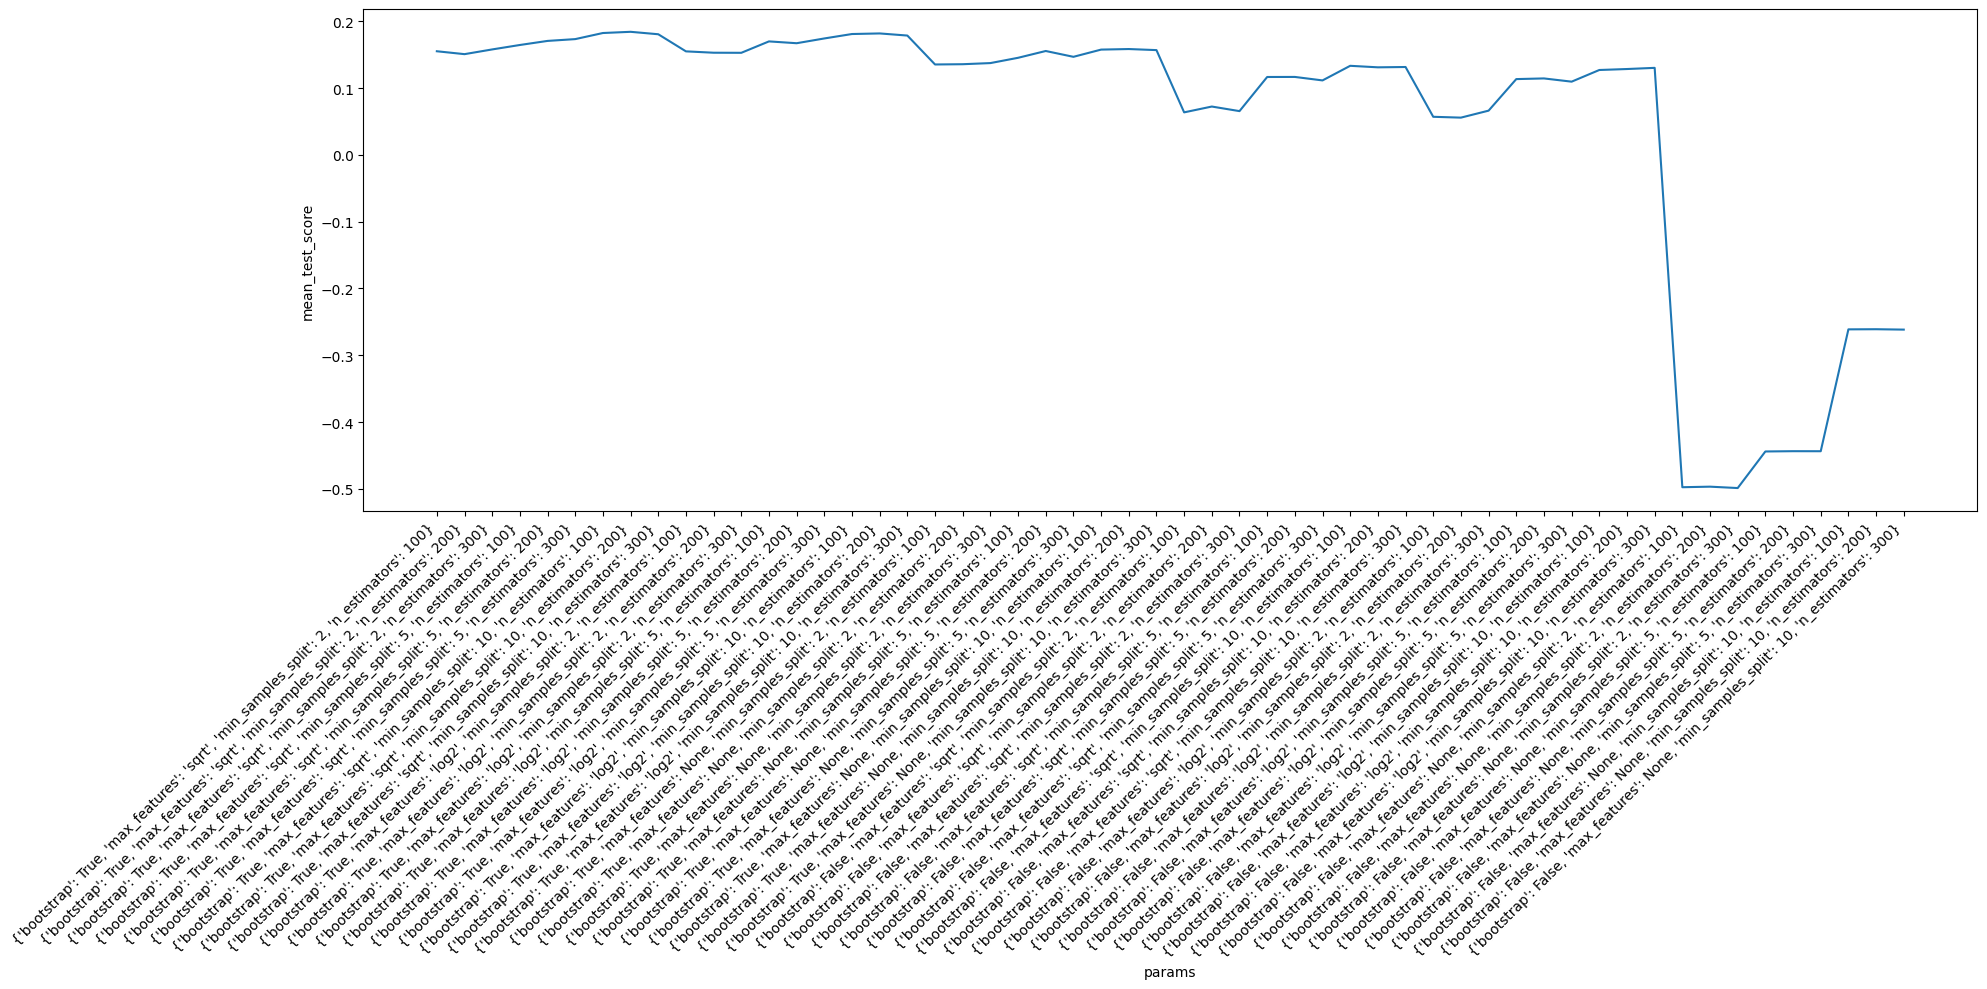

In [97]:
results = grid_search.cv_results_['mean_test_score']
params_combinations = [str(params) for params in grid_search.cv_results_['params']]

plt.figure(figsize=(20, 10))
plt.plot(results)
plt.xticks(np.arange(len(params_combinations)), params_combinations, rotation=45, ha='right')

plt.xlabel('params')
plt.ylabel('mean_test_score')
plt.tight_layout()
plt.show()

In [106]:
model = grid_search.best_estimator_

Y_test_pred = model.predict(X_test)
Y_train_pred = model.predict(X_train)

mse_test = mean_squared_error(y_test, Y_test_pred)
mse_train = mean_squared_error(y_train, Y_train_pred)

r2_test = r2_score(y_test, Y_test_pred)
r2_train = r2_score(y_train, Y_train_pred)

print("mse_test:", mse_test)
print("r2_test:", r2_test)

print("mse_train:", mse_train)
print("r2_train:", r2_train)

mse_test: 0.0037271508322796183
r2_test: 0.14582065076466333
mse_train: 0.001647191699533803
r2_train: 0.6446681577340498


Есть незначительные различия между mse на тренировочной и тестовой выборках, но я считаю, что ими можно пренебречь. Что менее интуитивно - r2 на тренировочной выборке хуже, чем на тестовой! Единственное мое предположение - изначально данные настолько неописуемы, что тестовую выборку проще описать той же моделью, чем тренировочную, из-за ее размера.

Т.к. mse получалось приемлемым, я решил оценить влияние гиперпараметров на r2. Из интересного - полный провал при использовании 'max_features' = None. r2 может быть отрицательным, обычно это означает, что модель плохо описывает данные (fitting the data), вот наглядный пример:

![](https://drive.google.com/uc?export=view&id=1iQQ93ze6jVIg099An9LnxdZfVzpcN_tE)

Хорошая модель может иметь низкое значение r2, важна совокупность метрик в целом, но ради эксперимента я попытался увеличить r2. Mse при этом остался низким.

**Теперь опишем полносвязную нейронную сеть:**

In [102]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

X = dataset.drop(['isbn13','isbn10', 'title', 'subtitle', 'authors', 'description', 'average_rating'], axis=1)
y = dataset['average_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

input_dim = X_train.shape[1]
# 2 layers
model = Sequential()
model.add(Dense(10, input_dim=input_dim, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

# compile
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1)

loss, mse = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test MSE: {mse}')

Epoch 1/50
307/307 [==============================] - 3s 5ms/step - loss: 0.3650 - mse: 0.3650 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 2/50
307/307 [==============================] - 1s 3ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 3/50
307/307 [==============================] - 1s 2ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 4/50
307/307 [==============================] - 1s 2ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 5/50
307/307 [==============================] - 1s 2ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 6/50
307/307 [==============================] - 1s 3ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 7/50
307/307 [==============================] - 1s 3ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 8/50
307/307 [==============================] - 1s 2ms/step - loss: 0.

In [104]:
Y_test_pred = model.predict(X_test)
Y_train_pred = model.predict(X_train)

mse_test = mean_squared_error(y_test, Y_test_pred)
mse_train = mean_squared_error(y_train, Y_train_pred)

r2_test = r2_score(y_test, Y_test_pred)
r2_train = r2_score(y_train, Y_train_pred)

print("mse_test:", mse_test)
print("r2_test:", r2_test)

print("mse_train:", mse_train)
print("r2_train:", r2_train)

171/171 [==============================] - 0s 1ms/step
mse_test: 0.004031032241208849
r2_test: 0.07617784965346475
mse_train: 0.00434116453454178
r2_train: 0.0635249120822311


Mse все еще низок, а вот r2 по сравнению со случайным лесом, уменьшилось с 0.15 до 0.07 на тестовой выборке. Результаты тестовой и тренирововчной выборок схожи, что очень хорошо, скорее всего, мы не переобучили модель.

# Выводы:



1.   Лучше всех себя показал случайный лес с гиперпараметрами.
2.   Линейная регрессия скорее всего не подходит для решения данной задачи.
3.   Несмотря на низкое значение r2, mse остается очень малым. Я не могу сделать однозначный вывод о переобучении или недообучении, так как на тестовой выборке модель показывает себя очень неплохо. Если бы я мог как-то учесть текстовый признак и имел бы больше вхождений в датасете, то скорее всего, модели работали бы лучше.
4.   В датасете много пропущенных значений, это негативно сказывается на обучении.
5.   Из предложенных методов самыми подходящими для решения данной задачи я считаю случайный лес и полносвязную нейронную сеть.
6.   При подборе гиперпараметров для нейронной сети можно было бы достичь результатов не хуже, а может даже и лучше, чем у случайного леса.

*Прим:* Я не стал строить confusion matrix и использовать логистическую регрессию, так как изначально не решал задачу классификации. Confusin matrix в чистом виде не может быть построена для задачи регрессии